About the Dataset
Experiment Overview: Free Trial Screener

At the time of this experiment, Udacity courses currently have two options on the course overview page: "start the free trial", and "access course materials". If the student clicks "start the free trial", they will be asked to enter their credit card information, and then they will be enrolled in a free trial for the paid version of the course. After 14 days, they will automatically be charged unless they cancel first. If the student clicks "access course materials", they will be able to view the videos and take the quizzes for free, but they will not receive coaching support or a verified certificate, and they will not submit their final project for feedback.

In the experiment, Udacity tested a change where if the student clicked "start the free trial", they were asked how much time they had available to devote to the course. If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion, and suggesting that the student might like to access the course materials for free. At this point, the student would have the option to continue enrolling in the free trial or access the course materials for free instead.

The objective of this pop up is to set up a clear expectation from the student, so that they would not drop out of the free trial due to time constraint. While does not significantly reduce the amount of student sign up for subscription after the free trial.

Hypothesis
The Objective offers 3 hypothesis:

    1/ Free Trial
- H0: The change caused no statistically difference in new enrollment for the free trial
- H1: The change caused a statistically difference in new enrollment for the free trial
-     2/ Drop out
- H0: The change caused no statistically difference in drop out during the free trial
- H1: The change caused a statistically difference in drop out during the free trial
    3/ Subscription
- H0: The change caused no statistically difference in new subscription after the free trial
- H1: The change caused a statistically difference in new subscription after the free trial

There are several metrics to consider for this test.

+ Number of cookies: number of cookies that view the course overview page.
+ Number of clicks: number of unique cookies that clicked the "free trial" button
+ Click-through-probability: number of clicks / number of cookies
+ Number of user-ids: number of user who enroll and complete checkout in the free trial
+ Gross conversion: number of user-ids / number of clicks
+ Retention: number of user who stay after 14 days / number of user-ids
+ Net conversion: nunber of user who stay after 14 days / number of clicks


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
ctrl = pd.read_csv('datasets/Final Project Results - Control.xls')

In [10]:
exp = pd.read_csv('datasets/Final Project Results - Experiment.xls')

In [14]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB


In [15]:
ctrl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB


In [16]:
exp['Group']='exp'

In [18]:
ctrl['Group']='ctrl'

In [20]:
combine = pd.concat([exp,ctrl])
combine

,Date,Pageviews,Clicks,Enrollments,Payments,Group
0,"Sat, Oct 11",7716,686,105.0,34.0,exp
1,"Sun, Oct 12",9288,785,116.0,91.0,exp
2,"Mon, Oct 13",10480,884,145.0,79.0,exp
3,"Tue, Oct 14",9867,827,138.0,92.0,exp
4,"Wed, Oct 15",9793,832,140.0,94.0,exp
...,...,...,...,...,...,...
32,"Wed, Nov 12",10134,801,NaN,NaN,ctrl
33,"Thu, Nov 13",9717,814,NaN,NaN,ctrl
34,"Fri, Nov 14",9192,735,NaN,NaN,ctrl
35,"Sat, Nov 15",8630,743,NaN,NaN,ctrl


In [50]:
temp = combine.groupby('Group').agg({'Pageviews':'sum','Clicks':'sum',"Enrollments":'sum','Payments':'sum'})
temp['Gross Conversion']=temp['Enrollments']/temp['Clicks']
temp['Net Conversion']=temp['Payments']/temp['Clicks']
temp['Retention']=temp['Payments']/temp['Enrollments']
temp

,Pageviews,Clicks,Enrollments,Payments,Gross Conversion,Net Conversion,Retention
Group,,,,,,,
ctrl,345543,28378,3785.0,2033.0,0.133378,0.071640,0.537120
exp,344660,28325,3423.0,1945.0,0.120847,0.068667,0.568215


+ Number of cookies(Pageviews) are roughly 50.1/49.9 split
+ We could see Pageviews and Clicks are similar, there is a noticable drop in Enrollments and Payments on the experience group.
+ Gross conversion, Net conversion.
+ But Retention is higher!

Lets dig deeper into this:

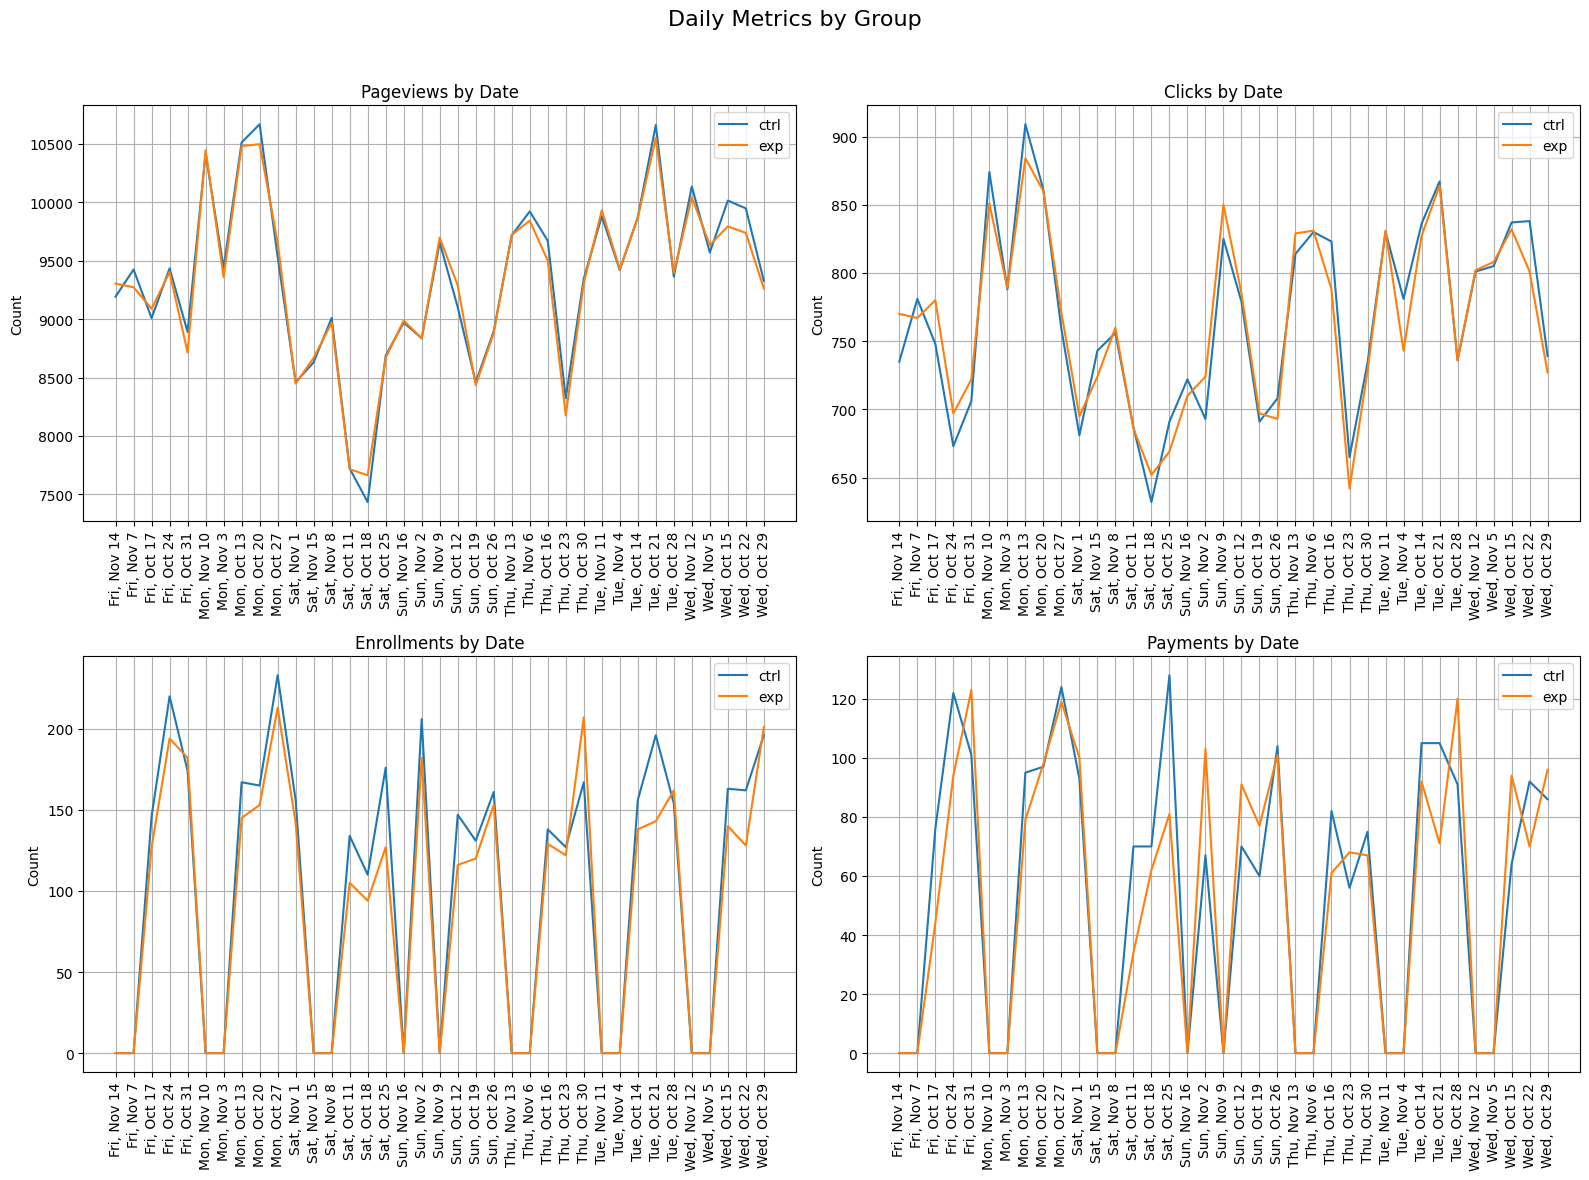

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Daily Metrics by Group', fontsize=16)

metrics = ['Pageviews', 'Clicks', 'Enrollments', 'Payments']
titles = ['Pageviews by Date', 'Clicks by Date', 
          'Enrollments by Date', 'Payments by Date']

for ax, metric, title in zip(axes.flat, metrics, titles):
    temp = combine.groupby(['Group', 'Date'])[metric].sum().unstack(fill_value=0)
    
    ax.plot(temp.columns, temp.loc['ctrl'], label='ctrl')
    ax.plot(temp.columns, temp.loc['exp'], label='exp')
    
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=90)
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

Overrall, look like the experiement group was doing worse than the ctrl group in most metric.
Lets perform the A/B Test to determind if the difference is significant

In [55]:
gross_conversion = np.array([[3785,28378-3785],[3423,28325-3423]])
chi2, p_chi, dof, expected = stats.chi2_contingency(gross_conversion)
print(f"Gross Conversion Chi-square p-value: {p_chi:.10f}")

net_conversion = np.array([[2033,28378-2033],[1945,28325-1945]])
chi2, p_chi, dof, expected = stats.chi2_contingency(net_conversion)
print(f"Net conversion Chi-square p-value: {p_chi:.10f}")

retention = np.array([[2033,3785-2033],[1945,3423-1945]])
chi2, p_chi, dof, expected = stats.chi2_contingency(retention)
print(f"Retention Chi-square p-value: {p_chi:.10f}")

Gross Conversion Chi-square p-value: 0.0000079612
Net conversion Chi-square p-value: 0.1708917887
Retention Chi-square p-value: 0.0086087366


Based on the test result and the raw number:
+ Gross conversion P-value < 0.05, meaning there is a significant difference, experiment group has lower enrollment rate after clicks.
+ Retention P-value < 0.05, meaning there is a significant difference, experiement group as lower dropout rate during free-trial.
+ Net converion P-value > 0.05, meaning there is no significant difference in payment after joining the free trial.

CONCLUSIONs:
+ The change did increased the retention rate during the free trial but reducing potentially frustrated student from enrollment.
+ The change did not decrease the net conversion rate, the propability of a user who clicks "Start free trial" eventually pays remain the same.
+ Recommendation: Launch the change since it reached the set out milestones during the experiment run